In [1]:
from __future__ import print_function, division

import shutil
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import torch.nn as nn

import os
import sys
import torch
from torch.nn import functional as F
import numpy as np
import glob
import random
from PIL import Image
from tqdm import tqdm
import argparse
from bisect import bisect_right, bisect_left

import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


from PIL import Image

from tqdm import tqdm
import os
import time
from datetime import datetime

%matplotlib inline

plt.ion()   # interactive mode


In [2]:
## Some functions


def return_idx(timestamps, data):
    "Return the idx of the timestamp of the camera"
    
    idx_sensor = []
    for temp in timestamps:
        idx=int(data[data['timestamp']==temp].index[0])
        idx_sensor.append(idx)
    return idx_sensor



In [3]:

def return_idx_single(temp, data):
    "Return the idx of the timestamp of the camera"
    
    idx_sensor = []
    idx = data[data['timestamp']==temp].index[0]

    return idx

# Import data

In [4]:
#Import csv data from folders

imu_data = pd.read_csv('/home/francesca/Desktop/francesca/data/mav0/imu0/data.csv')
camera_data = pd.read_csv('/home/francesca/Desktop/francesca/data/mav0/cam0/data.csv')
vicon_data = pd.read_csv('/home/francesca/Desktop/francesca/data/mav0/vicon0/data.csv')

# Drop the first row of the camera

camera_data=camera_data.drop(camera_data.index[[0]])

# re-assign name to columns

vicon_data.columns = ['timestamp','px','py','pz','qw','qx','qy','qz']
camera_data.columns = ['timestamp','filename']
imu_data.columns =['timestamp','wx','wy','wz','ax','ay','az']

# Get the timestamp of the camera and drop the index
camera_timestamps = camera_data['timestamp']
camera_timestamps = camera_timestamps.reset_index(drop=True)

### Interpolate Vicon data to get data at the same timestamp of the camera and IMU
# Vicon data

vicondata = vicon_data.copy() #create a copy

for i in range(len(camera_timestamps)):
    new_row=pd.DataFrame([[camera_timestamps[i],np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]], columns = ['timestamp','px','py','pz','qw','qx','qy','qz'])
    vicondata = pd.concat([vicondata, pd.DataFrame(new_row)], ignore_index=True)
    
vicondata.sort_values(by=['timestamp'],inplace=True, ascending=True)
vicondata = vicondata.reset_index(drop = True)
vicondata = vicondata.interpolate()

# Create a new vicon dataframe with the same timestamps of the camera

idx_vicon=return_idx(camera_timestamps,vicondata)
new_vicon = vicondata.ix[idx_vicon].reset_index(drop=True)

vicon_timestamp = new_vicon['timestamp'].values

# Let’s read the CSV and get the filenames and labels

file = pd.read_csv('/home/francesca/Desktop/francesca/data/mav0/cam0/image_data.csv')
file.drop(file.tail(1).index,inplace=True) # drop last n rows
file.to_csv('/home/francesca/Desktop/francesca/data/mav0/cam0/file.csv',index = None, header=True)


img_name = file.iloc[:, 1]
labels = file.iloc[:, 2:].as_matrix()
    

In [10]:
c_t = np.array(camera_timestamps)
new_imu_values = np.zeros((len(c_t),10,7))

for i in range(len(c_t)):
    idx_imu = return_idx_single(camera_timestamps.iloc[i], imu_data)
    new_imu_values[i][:][:] = imu_data.ix[idx_imu:idx_imu+9].reset_index(drop=True).values


new_imu_values = new_imu_values[:1920]


In [12]:
# Create new dataframe for images and save it

image_data = pd.merge(camera_data,new_vicon, on='timestamp').reset_index(drop=True)
image_data.to_csv(r'/home/francesca/Desktop/francesca/data/mav0/cam0/image_data.csv',index = None, header=True)

In [15]:
class NewDataset(Dataset):
    def __init__(self, csv_file, imu_data, root_dir):       
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.frame = pd.read_csv(csv_file)
        self.imu_data = imu_data
        # Second - 7th columns contains the angular rate and acceleration
        self.imu_arr = self.imu_data[:,:,1:]

        # Second column contains the image name
        self.image_arr = np.asarray(self.frame.iloc[:, 1])
        self.label_arr = np.asarray(self.frame.iloc[:, 2:])
        self.root_dir = root_dir
        # Transforms
        transformation = transforms.Compose([
            transforms.Resize(64),
            transforms.CenterCrop((64,96)),
            transforms.ToTensor(),
#             transforms.Normalize([0.4543, 0.4543, 0.4543],[0.3035, 0.3035, 0.3035])
        ])
        self.transform = transformation
        # Calculate len
        self.data_len = len(self.frame.index)
        transform_imu = transforms.Compose([
            transforms.ToTensor(),
        ])
        self.transform_imu = transform_imu
    def __len__(self):
        return self.data_len
    
    def __getitem__(self, idx):
#         print(idx)
        single_image_name = self.image_arr[idx]
        fp = self.root_dir
        # Open image
#         image = PIL.Image.open(fp + single_image_name).convert('RGB')
        image = Image.open(fp + single_image_name).convert('RGB')
        image = self.transform(image)
        imu_data = self.imu_arr[idx]
#         imu_data = self.transform_imu( imu_data)
        # Get label of the image based on the cropped pandas column
        labels = self.label_arr[idx]

        return image, imu_data, labels

In [16]:
dataset = NewDataset(csv_file='/home/francesca/Desktop/francesca/data/mav0/cam0/file.csv', 
                         imu_data=new_imu_values,
                           root_dir='/home/francesca/Desktop/francesca/data/mav0/cam0/data/')

dataloader = DataLoader(dataset, batch_size=32,
                        shuffle=False, num_workers=0)

In [19]:
batch_size = 32
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader_1 = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

In [20]:
batch_size = 32
validation_split = .2
shuffle_dataset = False
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader_1 = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

In [22]:
def quaternion_angular_error(q1, q2):
    """
    angular error between two quaternions
    :param q1: (4, )
    :param q2: (4, )
    :return:
    """
    d = abs(np.dot(q1, q2))
    abs_q1 = np.linalg.norm(q1)
    abs_q2 = np.linalg.norm(q2)
    d = d / (abs_q1 * abs_q2)
    d = min(1.0, max(-1.0, d))
    theta = 2 * np.arccos(d) * 180 / np.pi
    return theta

In [24]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

# class UnFlatten(nn.Module):
#     def forward(self, input):
#         return input.view(input.size(0), -1, 1, 1)


class FlattenIMU(nn.Module):
    def forward(self, input):
        return input.view(32, -1)

class IMUNet(torch.nn.Module):
    
    def __init__(self, feature_extractor, num_features=128, dropout=0.5,
                 track_running_stats=False, pretrained=False):
        super(IMUNet, self).__init__()
        

        self.dropout = dropout
        self.feature_extractor = feature_extractor
        self.feature_extractor.avgpool = torch.nn.AdaptiveAvgPool2d(1)
        fc_in_features = self.feature_extractor.fc.in_features
        
        
        self.IMU_fc = nn.Sequential(
            Flatten(),
            nn.Linear(7, 1024),
            nn.ReLU(),
            nn.Linear(1024, 32),
            nn.ReLU(),
            FlattenIMU()
        )
        
        self.rnn = torch.nn.LSTM(
            input_size=6, 
            hidden_size= 64*2, 
            num_layers=4,
            batch_first=True)
        
        self.flat_imu = FlattenIMU()
        self.linear = nn.Linear(128,num_features)

        self.fc3 = torch.nn.Linear( 4096, num_features)
        self.feature_extractor.fc = torch.nn.Linear(fc_in_features, num_features)
        # Translation
        self.fc_xyz = torch.nn.Linear(num_features, 3)

        # Rotation in quaternions
        self.fc_quat = torch.nn.Linear(num_features, 4)
        
    def extract_features(self, image):
        x_features = self.feature_extractor(image)
        x_features = F.relu(x_features)
        if self.dropout > 0:
            x_features = F.dropout(x_features, p=self.dropout, training=self.training)
        return x_features
    
    def forward(self, data_input):
        image = data_input[0].cuda()
        imu_data = data_input[1].type(torch.FloatTensor).cuda()
#         print(imu_data.size()[1])
        #Images
        if type(image) is list:
            x_features = [self.extract_features(xi) for xi in image]
        elif torch.is_tensor(image):
            x_features = self.extract_features(image)
            
        imu_feat = imu_data
        r_out, (h_n, h_c) = self.rnn(imu_feat)
        imu_out = self.linear(r_out[:, -1, :]) # we want just the last time 


        imu_out = self.flat_imu(imu_out) # we want just the last time 
        
        x = torch.cat((x_features, imu_out), dim=1)
#         print(x.size)
        x = F.relu(self.fc3(x))

        if type(x) is list:
            x_translations = [self.fc_xyz(xi) for xi in x]
            x_rotations = [self.fc_quat(xi) for xi in x]
            x_poses = [torch.cat((xt, xr), dim=1) for xt, xr in zip(x_translations, x_rotations)]  
        elif torch.is_tensor(x):
            x_translations = self.fc_xyz(x) 
            x_rotations = self.fc_quat(x)

            x_poses = torch.cat((x_translations, x_rotations), dim=1)

        return x_poses

In [25]:
import torchvision.models as models
import torch.optim as optim
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Create pretrained feature extractor
feature_extractor = models.resnet18(pretrained=True)

# Num features for the last layer before pose regressor
num_features = 2048

# Create model
model = IMUNet(feature_extractor, num_features=num_features, pretrained=True)
model = model.to(device)



In [26]:
model = IMUNet(feature_extractor, num_features=num_features, pretrained=True)
model = model.to(device)


out = model(next(iter(dataloader))[0:2])
out.size()


torch.Size([32, 7])

In [27]:
import torchvision.models as models
import torch.optim as optim


# Create pretrained feature extractor
feature_extractor = models.resnet18(pretrained=True)


# print(Net(feature_extractor))

In [30]:
# Select primary device

import os

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
   

In [31]:
class AverageMeter():
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, value, n=1):
        self.val = value
        self.count += n
        self.sum += value * n
        self.avg = self.sum / self.count

In [32]:
def train(train_loader, model, criterion, optimizer, epoch, max_epoch, log_freq=1, print_sum=True):
    
    position_loss=[]
    orientation_loss = []
    
    model.train()
    losses = AverageMeter()
    epoch_time = time.time()
    
    gt_poses = np.empty((0, 7))
    pred_poses = np.empty((0, 7))
    
    end = time.time()
    
    for idx, data in enumerate(train_loader):
        if idx == 1920:
            idx = 1919
        batch_images= data[0].cuda()
        imu_data= data[1].unsqueeze(0).cuda()
    
        batch_poses= data[2].cuda()
        data_time = (time.time() - end)
        batch_images = batch_images.to(device)
        batch_poses = batch_poses.to(device)
        batch_poses = torch.tensor(batch_poses, dtype=torch.float, device=device)
#         imu_data = imu_data.to(device).double()
        imu_data = torch.tensor(imu_data, dtype=torch.float, device=device)
        out = model(data[0:2])

        loss = criterion(out, batch_poses)
              
        # Training step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.update(loss.data[0], len(batch_images) * batch_images.size(0))
        
        
        # move data to cpu & numpy
        bp = batch_poses.detach().cpu().numpy()
        outp = out.detach().cpu().numpy()
        gt_poses = np.vstack((gt_poses, bp))
        pred_poses = np.vstack((pred_poses, outp))
        
        batch_time = (time.time() - end)
        end = time.time()
        
        if log_freq != 0 and idx % log_freq == 0:
            print('Epoch: [{}/{}]\tBatch: [{}/{}]\t'
                  'Time: {batch_time:.3f}\t'
                  'Data Time: {data_time:.3f}\t'
                  'Loss: {losses.val:.3f}\t'
                  'Avg Loss: {losses.avg:.3f}\t'.format(
                   epoch, max_epoch - 1, idx, len(train_loader) - 1,
                   batch_time=batch_time, data_time=data_time, losses=losses))
            
        t_loss = np.asarray([np.linalg.norm(p - t) for p, t in zip(pred_poses[:, :3], gt_poses[:, :3])])
        q_loss = np.asarray([quaternion_angular_error(p, t) for p, t in zip(pred_poses[:, 3:], gt_poses[:, 3:])])
    position_loss.append(t_loss)
    orientation_loss.append(q_loss)

    return losses
    
def validate(val_loader, model, criterion, epoch, log_freq=1, print_sum=True):
    
    losses = AverageMeter()
    position_loss_testing=[]
    orientation_loss_testing=[]
    
    # set model to evaluation
    model.eval()
    
    with torch.no_grad():
        epoch_time = time.time()
        end = time.time()
        for idx, data in enumerate(val_loader):


            batch_images= data[0].cuda()
            imu_data= data[1].cuda()
        
            batch_poses= data[2].cuda()
            data_time = time.time() - end
            
            batch_images = batch_images.to(device)
            batch_poses = batch_poses.to(device)
            batch_poses = torch.tensor(batch_poses, dtype=torch.float, device=device)
            imu_data = imu_data.to(device)
            imu_data = torch.tensor(imu_data, dtype=torch.float, device=device)


            # compute model output
            out = model(data[:2])
            loss = criterion(out, batch_poses)
            
            losses.update(loss.data[0], len(data[0]) * data[0].size(0))


            batch_time = time.time() - end
            end = time.time()
            if log_freq != 0 and idx % log_freq == 0:
                print('Val Epoch: {}\t'
                      'Time: {batch_time:.3f}\t'
                      'Data Time: {data_time:.3f}\t'
                      'Loss: {losses.val:.3f}\t'
                      'Avg Loss: {losses.avg:.3f}'.format(
                       epoch, batch_time=batch_time, data_time=data_time, losses=losses))

    return losses
        

In [33]:
import torchvision.models as models
import torch.optim as optim


# Create pretrained feature extractor
feature_extractor = models.resnet18(pretrained=True)

# Num features for tahe last layer before pose regressor
num_features = 2048



In [35]:

imu = next(iter(train_loader))[1]
# Create model
model = IMUNet(feature_extractor, num_features=num_features, pretrained=True)
model = model.to(device)

# Criterion
criterion = NetCriterion(learn_beta=True)
criterion = criterion.to(device)

# Add all params for optimization
param_list = [{'params': model.parameters()}]
if criterion.learn_beta:
    # Add sx and sq from loss function to optimizer params
    param_list.append({'params': criterion.parameters()})

# Create optimizer
# optimizer = optim.Adam(params=param_list, lr=1e-5, weight_decay=0.0005)
optimizer = optim.Adam(params=param_list, lr=0.01, weight_decay=0.0001)


# Epochs to train
start_epoch = 0

# n_epochs = 10

In [36]:
n_epochs = start_epoch + 620
train_loss=[]
test_loss=[]
print('Training ...')
val_freq = 10
for e in range(start_epoch, n_epochs):
    losses = train(train_loader, model, criterion, optimizer, e, n_epochs, log_freq=100)
    train_loss.append(losses)
    if e % val_freq == 0:
#         end = time.time()
        loss = validate(validation_loader, model, criterion, e, log_freq=100)
        test_loss.append(loss)


start_epoch = n_epochs

print('n_epochs = {}'.format(n_epochs))

Training ...
Epoch: [0/619]	Batch: [0/47]	Time: 0.221	Data Time: 0.164	Loss: 5.847	Avg Loss: 5.847	
Val Epoch: 0	Time: 0.169	Data Time: 0.150	Loss: 5.040	Avg Loss: 5.040
Epoch: [1/619]	Batch: [0/47]	Time: 0.207	Data Time: 0.152	Loss: 5.352	Avg Loss: 5.352	
Epoch: [2/619]	Batch: [0/47]	Time: 0.199	Data Time: 0.161	Loss: 5.499	Avg Loss: 5.499	
Epoch: [3/619]	Batch: [0/47]	Time: 0.182	Data Time: 0.143	Loss: 5.715	Avg Loss: 5.715	
Epoch: [4/619]	Batch: [0/47]	Time: 0.187	Data Time: 0.148	Loss: 5.272	Avg Loss: 5.272	
Epoch: [5/619]	Batch: [0/47]	Time: 0.185	Data Time: 0.145	Loss: 5.652	Avg Loss: 5.652	
Epoch: [6/619]	Batch: [0/47]	Time: 0.190	Data Time: 0.149	Loss: 5.224	Avg Loss: 5.224	
Epoch: [7/619]	Batch: [0/47]	Time: 0.187	Data Time: 0.147	Loss: 5.846	Avg Loss: 5.846	
Epoch: [8/619]	Batch: [0/47]	Time: 0.190	Data Time: 0.148	Loss: 5.593	Avg Loss: 5.593	
Epoch: [9/619]	Batch: [0/47]	Time: 0.186	Data Time: 0.147	Loss: 5.031	Avg Loss: 5.031	
Epoch: [10/619]	Batch: [0/47]	Time: 0.188	Data 

Epoch: [86/619]	Batch: [0/47]	Time: 0.187	Data Time: 0.146	Loss: 3.068	Avg Loss: 3.068	
Epoch: [87/619]	Batch: [0/47]	Time: 0.189	Data Time: 0.148	Loss: 2.895	Avg Loss: 2.895	
Epoch: [88/619]	Batch: [0/47]	Time: 0.189	Data Time: 0.149	Loss: 2.689	Avg Loss: 2.689	
Epoch: [89/619]	Batch: [0/47]	Time: 0.197	Data Time: 0.148	Loss: 2.767	Avg Loss: 2.767	
Epoch: [90/619]	Batch: [0/47]	Time: 0.193	Data Time: 0.146	Loss: 2.709	Avg Loss: 2.709	
Val Epoch: 90	Time: 0.159	Data Time: 0.150	Loss: 2.038	Avg Loss: 2.038
Epoch: [91/619]	Batch: [0/47]	Time: 0.199	Data Time: 0.152	Loss: 2.571	Avg Loss: 2.571	
Epoch: [92/619]	Batch: [0/47]	Time: 0.189	Data Time: 0.147	Loss: 2.599	Avg Loss: 2.599	
Epoch: [93/619]	Batch: [0/47]	Time: 0.193	Data Time: 0.149	Loss: 2.310	Avg Loss: 2.310	
Epoch: [94/619]	Batch: [0/47]	Time: 0.185	Data Time: 0.147	Loss: 2.220	Avg Loss: 2.220	
Epoch: [95/619]	Batch: [0/47]	Time: 0.191	Data Time: 0.150	Loss: 2.610	Avg Loss: 2.610	
Epoch: [96/619]	Batch: [0/47]	Time: 0.202	Data Ti

Epoch: [171/619]	Batch: [0/47]	Time: 0.191	Data Time: 0.149	Loss: 0.654	Avg Loss: 0.654	
Epoch: [172/619]	Batch: [0/47]	Time: 0.188	Data Time: 0.148	Loss: 0.616	Avg Loss: 0.616	
Epoch: [173/619]	Batch: [0/47]	Time: 0.192	Data Time: 0.145	Loss: 0.675	Avg Loss: 0.675	
Epoch: [174/619]	Batch: [0/47]	Time: 0.192	Data Time: 0.149	Loss: 0.527	Avg Loss: 0.527	
Epoch: [175/619]	Batch: [0/47]	Time: 0.185	Data Time: 0.147	Loss: 0.673	Avg Loss: 0.673	
Epoch: [176/619]	Batch: [0/47]	Time: 0.186	Data Time: 0.147	Loss: 0.681	Avg Loss: 0.681	
Epoch: [177/619]	Batch: [0/47]	Time: 0.196	Data Time: 0.149	Loss: 0.489	Avg Loss: 0.489	
Epoch: [178/619]	Batch: [0/47]	Time: 0.187	Data Time: 0.146	Loss: 0.679	Avg Loss: 0.679	
Epoch: [179/619]	Batch: [0/47]	Time: 0.194	Data Time: 0.150	Loss: 0.632	Avg Loss: 0.632	
Epoch: [180/619]	Batch: [0/47]	Time: 0.203	Data Time: 0.146	Loss: 0.697	Avg Loss: 0.697	
Val Epoch: 180	Time: 0.160	Data Time: 0.151	Loss: 0.403	Avg Loss: 0.403
Epoch: [181/619]	Batch: [0/47]	Time: 0

Epoch: [257/619]	Batch: [0/47]	Time: 0.184	Data Time: 0.145	Loss: 0.546	Avg Loss: 0.546	
Epoch: [258/619]	Batch: [0/47]	Time: 0.183	Data Time: 0.143	Loss: 0.620	Avg Loss: 0.620	
Epoch: [259/619]	Batch: [0/47]	Time: 0.186	Data Time: 0.146	Loss: 0.552	Avg Loss: 0.552	
Epoch: [260/619]	Batch: [0/47]	Time: 0.191	Data Time: 0.149	Loss: 0.464	Avg Loss: 0.464	
Val Epoch: 260	Time: 0.168	Data Time: 0.150	Loss: 0.359	Avg Loss: 0.359
Epoch: [261/619]	Batch: [0/47]	Time: 0.185	Data Time: 0.145	Loss: 0.544	Avg Loss: 0.544	
Epoch: [262/619]	Batch: [0/47]	Time: 0.187	Data Time: 0.143	Loss: 0.609	Avg Loss: 0.609	
Epoch: [263/619]	Batch: [0/47]	Time: 0.181	Data Time: 0.141	Loss: 0.576	Avg Loss: 0.576	
Epoch: [264/619]	Batch: [0/47]	Time: 0.188	Data Time: 0.148	Loss: 0.402	Avg Loss: 0.402	
Epoch: [265/619]	Batch: [0/47]	Time: 0.186	Data Time: 0.143	Loss: 0.398	Avg Loss: 0.398	
Epoch: [266/619]	Batch: [0/47]	Time: 0.187	Data Time: 0.146	Loss: 0.458	Avg Loss: 0.458	
Epoch: [267/619]	Batch: [0/47]	Time: 0

Epoch: [342/619]	Batch: [0/47]	Time: 0.192	Data Time: 0.149	Loss: 1.369	Avg Loss: 1.369	
Epoch: [343/619]	Batch: [0/47]	Time: 0.194	Data Time: 0.144	Loss: 1.500	Avg Loss: 1.500	
Epoch: [344/619]	Batch: [0/47]	Time: 0.188	Data Time: 0.148	Loss: 1.479	Avg Loss: 1.479	
Epoch: [345/619]	Batch: [0/47]	Time: 0.190	Data Time: 0.151	Loss: 1.532	Avg Loss: 1.532	
Epoch: [346/619]	Batch: [0/47]	Time: 0.191	Data Time: 0.144	Loss: 1.610	Avg Loss: 1.610	
Epoch: [347/619]	Batch: [0/47]	Time: 0.205	Data Time: 0.156	Loss: 1.514	Avg Loss: 1.514	
Epoch: [348/619]	Batch: [0/47]	Time: 0.187	Data Time: 0.148	Loss: 1.595	Avg Loss: 1.595	
Epoch: [349/619]	Batch: [0/47]	Time: 0.188	Data Time: 0.147	Loss: 1.862	Avg Loss: 1.862	
Epoch: [350/619]	Batch: [0/47]	Time: 0.185	Data Time: 0.143	Loss: 1.796	Avg Loss: 1.796	
Val Epoch: 350	Time: 0.161	Data Time: 0.152	Loss: 1.695	Avg Loss: 1.695
Epoch: [351/619]	Batch: [0/47]	Time: 0.186	Data Time: 0.146	Loss: 1.916	Avg Loss: 1.916	
Epoch: [352/619]	Batch: [0/47]	Time: 0

Epoch: [428/619]	Batch: [0/47]	Time: 0.181	Data Time: 0.145	Loss: 1.109	Avg Loss: 1.109	
Epoch: [429/619]	Batch: [0/47]	Time: 0.184	Data Time: 0.145	Loss: 1.124	Avg Loss: 1.124	
Epoch: [430/619]	Batch: [0/47]	Time: 0.181	Data Time: 0.144	Loss: 1.098	Avg Loss: 1.098	
Val Epoch: 430	Time: 0.158	Data Time: 0.149	Loss: 1.074	Avg Loss: 1.074
Epoch: [431/619]	Batch: [0/47]	Time: 0.188	Data Time: 0.147	Loss: 1.100	Avg Loss: 1.100	
Epoch: [432/619]	Batch: [0/47]	Time: 0.181	Data Time: 0.145	Loss: 1.094	Avg Loss: 1.094	
Epoch: [433/619]	Batch: [0/47]	Time: 0.181	Data Time: 0.145	Loss: 1.098	Avg Loss: 1.098	
Epoch: [434/619]	Batch: [0/47]	Time: 0.183	Data Time: 0.145	Loss: 3.191	Avg Loss: 3.191	
Epoch: [435/619]	Batch: [0/47]	Time: 0.181	Data Time: 0.144	Loss: 1.069	Avg Loss: 1.069	
Epoch: [436/619]	Batch: [0/47]	Time: 0.182	Data Time: 0.144	Loss: 1.105	Avg Loss: 1.105	
Epoch: [437/619]	Batch: [0/47]	Time: 0.182	Data Time: 0.145	Loss: 1.103	Avg Loss: 1.103	
Epoch: [438/619]	Batch: [0/47]	Time: 0

Epoch: [513/619]	Batch: [0/47]	Time: 0.182	Data Time: 0.145	Loss: 1.034	Avg Loss: 1.034	
Epoch: [514/619]	Batch: [0/47]	Time: 0.184	Data Time: 0.144	Loss: 1.016	Avg Loss: 1.016	
Epoch: [515/619]	Batch: [0/47]	Time: 0.184	Data Time: 0.145	Loss: 1.031	Avg Loss: 1.031	
Epoch: [516/619]	Batch: [0/47]	Time: 0.185	Data Time: 0.146	Loss: 1.011	Avg Loss: 1.011	
Epoch: [517/619]	Batch: [0/47]	Time: 0.184	Data Time: 0.149	Loss: 1.026	Avg Loss: 1.026	
Epoch: [518/619]	Batch: [0/47]	Time: 0.182	Data Time: 0.146	Loss: 1.011	Avg Loss: 1.011	
Epoch: [519/619]	Batch: [0/47]	Time: 0.189	Data Time: 0.149	Loss: 1.009	Avg Loss: 1.009	
Epoch: [520/619]	Batch: [0/47]	Time: 0.186	Data Time: 0.147	Loss: 1.005	Avg Loss: 1.005	
Val Epoch: 520	Time: 0.158	Data Time: 0.149	Loss: 0.993	Avg Loss: 0.993
Epoch: [521/619]	Batch: [0/47]	Time: 0.184	Data Time: 0.146	Loss: 1.022	Avg Loss: 1.022	
Epoch: [522/619]	Batch: [0/47]	Time: 0.183	Data Time: 0.145	Loss: 1.020	Avg Loss: 1.020	
Epoch: [523/619]	Batch: [0/47]	Time: 0

Epoch: [599/619]	Batch: [0/47]	Time: 0.190	Data Time: 0.152	Loss: 1.177	Avg Loss: 1.177	
Epoch: [600/619]	Batch: [0/47]	Time: 0.185	Data Time: 0.148	Loss: 1.213	Avg Loss: 1.213	
Val Epoch: 600	Time: 0.170	Data Time: 0.151	Loss: 1.255	Avg Loss: 1.255
Epoch: [601/619]	Batch: [0/47]	Time: 0.186	Data Time: 0.145	Loss: 1.275	Avg Loss: 1.275	
Epoch: [602/619]	Batch: [0/47]	Time: 0.184	Data Time: 0.146	Loss: 1.285	Avg Loss: 1.285	
Epoch: [603/619]	Batch: [0/47]	Time: 0.185	Data Time: 0.146	Loss: 1.284	Avg Loss: 1.284	
Epoch: [604/619]	Batch: [0/47]	Time: 0.185	Data Time: 0.147	Loss: 1.271	Avg Loss: 1.271	
Epoch: [605/619]	Batch: [0/47]	Time: 0.186	Data Time: 0.146	Loss: 1.244	Avg Loss: 1.244	
Epoch: [606/619]	Batch: [0/47]	Time: 0.196	Data Time: 0.147	Loss: 1.267	Avg Loss: 1.267	
Epoch: [607/619]	Batch: [0/47]	Time: 0.183	Data Time: 0.145	Loss: 1.270	Avg Loss: 1.270	
Epoch: [608/619]	Batch: [0/47]	Time: 0.192	Data Time: 0.152	Loss: 1.276	Avg Loss: 1.276	
Epoch: [609/619]	Batch: [0/47]	Time: 0

In [37]:
torch.save(model, 'LSTM_pos_workin2_v2.torch')

In [41]:
def model_results_pred_gt(model, dataloader):
    
    model.eval()

    gt_poses = np.empty((0, 7))
    pred_poses = np.empty((0, 7))

    for idx, data in enumerate(dataloader):
        batch_images = data[0].cuda()
        batch_imu = data[1].cuda()
        batch_poses  = data[2].cuda()
        batch_images = batch_images.to(device)
        batch_imu = batch_imu.to(device)
        batch_imu = torch.tensor(batch_imu, dtype=torch.float, device=device)
        batch_poses = batch_poses.to(device)
        batch_poses = torch.tensor(batch_poses, dtype=torch.float, device=device)
        out = model(data[0:2])        
        loss = criterion(out, batch_poses)
        bp = batch_poses.detach().cpu().numpy()
        outp = out.detach().cpu().numpy()
        gt_poses = np.vstack((gt_poses, bp))
        pred_poses = np.vstack((pred_poses, outp))

    gt_poses[:, :3] = gt_poses[:, :3] 
    pred_poses[:, :3] = pred_poses[:, :3] 
    
    return pred_poses, gt_poses

print('\n=== Test Training Dataset ======')
pred_poses, gt_poses = model_results_pred_gt(model, train_loader)

print('gt_poses = {}'.format(gt_poses.shape))
print('pred_poses = {}'.format(pred_poses.shape))
t_loss = np.asarray([np.linalg.norm(p - t) for p, t in zip(pred_poses[:, :3], gt_poses[:, :3])])
q_loss = np.asarray([quaternion_angular_error(p, t) for p, t in zip(pred_poses[:, 3:], gt_poses[:, 3:])])

print('Translation(T) error in meters and Rotation(R) error in degrees:')
print('T: median = {:.3f}, mean = {:.3f}'.format(np.median(t_loss), np.mean(t_loss)))
print('R: median = {:.3f}, mean = {:.3f}'.format(np.median(q_loss), np.mean(q_loss)))

# Save for later visualization
pred_poses_train = pred_poses
gt_poses_train = gt_poses




=== Test Training Dataset ======
gt_poses = (1536, 7)
pred_poses = (1536, 7)
Translation(T) error in meters and Rotation(R) error in degrees:
T: median = 0.066, mean = 0.072
R: median = 4.047, mean = 4.604


In [42]:
print('\n=== Test Validation Dataset ======')
pred_poses, gt_poses = model_results_pred_gt(model, validation_loader)

print('gt_poses = {}'.format(gt_poses.shape))
print('pred_poses = {}'.format(pred_poses.shape))
t_loss = np.asarray([np.linalg.norm(p - t) for p, t in zip(pred_poses[:, :3], gt_poses[:, :3])])
q_loss = np.asarray([quaternion_angular_error(p, t) for p, t in zip(pred_poses[:, 3:], gt_poses[:, 3:])])

print('Translation(T) error in meters and Rotation(R) error in degrees:')
print('T: median = {:.3f}, mean = {:.3f}'.format(np.median(t_loss), np.mean(t_loss)))
print('R: median = {:.3f}, mean = {:.3f}'.format(np.median(q_loss), np.mean(q_loss)))

# Save for later visualization
pred_poses_val = pred_poses
gt_poses_val = gt_poses


=== Test Validation Dataset ======
gt_poses = (384, 7)
pred_poses = (384, 7)
Translation(T) error in meters and Rotation(R) error in degrees:
T: median = 0.041, mean = 0.052
R: median = 2.215, mean = 2.545


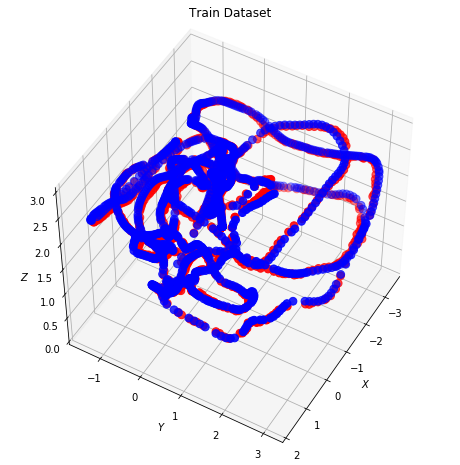

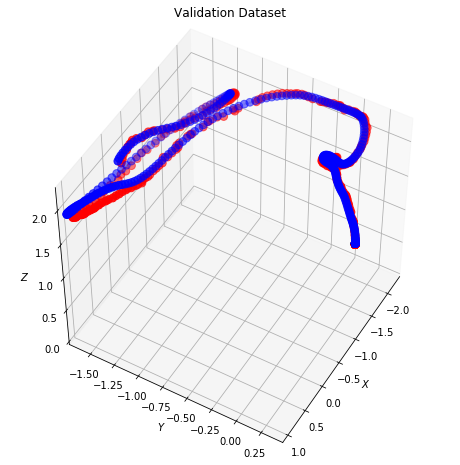

In [43]:
from mpl_toolkits.mplot3d import Axes3D

def calc_poses_params(poses, pose_format='full-mat'):
    """Calculates min, max, mean and std of translations of the poses"""

    p = poses[0]
    allp = extract_translation(p, pose_format)

    for p in poses[1:]:
        allp = np.vstack((allp, extract_translation(p, pose_format)))

    p_min = np.min(allp, axis=0)
    p_max = np.max(allp, axis=0)
    p_mean = np.mean(allp, axis=0)
    p_std = np.std(allp, axis=0)

    return p_min, p_max, p_mean, p_std

def set_3d_axes_limits(ax, poses, pose_format='quat'):
    p_min, p_max, p_mean, p_std = calc_poses_params(poses, pose_format=pose_format)
    ax.set_xlim(p_min[0], p_max[0])
    ax.set_ylim(p_min[1], p_max[1])
    ax.set_zlim(int(p_min[2] - 1), p_max[2])
    return p_min, p_max, p_mean, p_std

def extract_translation(p, pose_format='full-mat'):
    if pose_format == 'full-mat':
        return p[0:3, 3]
    elif pose_format == 'quat':
        return p[:3]
    else:
        warnings.warn("pose_format should be either 'full-mat' or 'quat'")
        return p


def draw_pred_gt_poses(pred_poses, gt_poses):
    fig = plt.figure(figsize=(8, 8))
    ax = plt.axes(projection='3d')

    ax.set_xlabel('$X$')
    ax.set_ylabel('$Y$')
    ax.set_zlabel('$Z$')
    ax.view_init(50, 30)

    all_poses = np.concatenate((pred_poses, gt_poses))
    p_min, _, _, _ = set_3d_axes_limits(ax, all_poses, pose_format='quat')
    
    draw_poses(ax, pred_poses[:, :3], proj=False, proj_z=int(p_min[2] - 1), c='r', s=60)
    draw_poses(ax, gt_poses[:, :3], proj=False, proj_z=int(p_min[2] - 1), c='b', s=60)
    for i in range(pred_poses.shape[0]):
        pp = pred_poses[i, :3]
        gp = gt_poses[i, :3]
        pps = np.vstack((pp, gp))
        ax.plot(pps[:, 0], pps[:, 1], pps[:, 2], c=(0.7, 0.7, 0.7, 0.4))
        
    plt.draw()
    
def draw_poses(ax, poses, c='b', s=20, proj=False, proj_z=0, pose_format='quat'):
    """Draws the list of poses.
    Args:
        ax (Axes3D): 3D axes
        poses (list): Poses list
        c: matplotlib color
        s: matplotlib size
        proj (bool): True if draw projection of a path on z-axis
        proj_z (float): Coord for z-projection
    """
    coords = np.zeros((len(poses), 3))
    for i, p in enumerate(poses):
        # coords[i] = p[:3, 3]
        # coords[i] = p
        coords[i] = extract_translation(p, pose_format=pose_format)

    # Draw projection
    if proj:
        if len(poses) > 1:
            ax.plot(coords[:, 0], coords[:, 1], proj_z, c='g')
        elif len(poses) == 1:
            ax.scatter(coords[:, 0], coords[:, 1], proj_z, c=c)

    # Draw path
    ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c=c, s=s)


def draw_poses_list(ax, poses_list):
    """Draw list of lists of poses."""
    for poses in poses_list:
        draw_poses(ax, poses)


    
# print(pred_poses_train)
# print(gt_poses_train)

# Draw predicted vs ground truth poses
draw_pred_gt_poses(pred_poses_train, gt_poses_train)
plt.title('Train Dataset')
plt.show()


draw_pred_gt_poses(pred_poses_val, gt_poses_val)
plt.title('Validation Dataset')
plt.show()